<a href="https://colab.research.google.com/github/yuann403/BI/blob/main/week2_LSTM%E6%A8%A1%E5%9E%8B%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# 加載數據
def parse_date(x):
  dt = pd.to_datetime(x)
  return dt.replace(tzinfo=None)

df = pd.read_csv('/content/NVidia_stock_history.csv', parse_dates=['Date'], date_parser=parse_date)

# 查看數據結構
print("股價數據：")
print(df.head())


<ipython-input-2-e07f7a03f298>:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('/content/NVidia_stock_history.csv', parse_dates=['Date'], date_parser=parse_date)


股價數據：
        Date      Open      High       Low     Close      Volume  Dividends  \
0 1999-01-22  0.040129  0.044786  0.035590  0.037621  2714688000        0.0   
1 1999-01-25  0.040607  0.042039  0.037621  0.041562   510480000        0.0   
2 1999-01-26  0.042039  0.042876  0.037740  0.038337   343200000        0.0   
3 1999-01-27  0.038457  0.039412  0.036307  0.038218   244368000        0.0   
4 1999-01-28  0.038218  0.038457  0.037859  0.038098   227520000        0.0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  


In [3]:
# 並篩選2024年以後的資料
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] >= pd.to_datetime('2019-08-28')]

# 提取收盤價
stock_data = df['Close'].values.reshape(-1, 1)

# 使用MinMaxScaler將資料標準化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

# 自訂窗口大小
window_size = 120  # 使用過去 120 天的資料預測未來價格

In [4]:
# 創建輸入和輸出數據集
def create_dataset(data, window_size):
  X, Y = [], []
  for i in range(len(data) - window_size):
    X.append(data[i:i+window_size, 0])  # 過去 window_size 天的數據
    Y.append(data[i+window_size, 0])   # 第 window_size+1 天的數據
  return np.array(X), np.array(Y)

X, Y = create_dataset(scaled_data, window_size)

In [5]:
# 切分為訓練集（80%）和測試集（20%）
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# 重塑數據以適配 LSTM 的輸入格式 (samples, time_steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [6]:
# 建立 LSTM 模型
model = Sequential()

# 第一層 LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))

# 第二層 LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# 全連接層
model.add(Dense(units=25))
model.add(Dense(units=1))  # 輸出未來一天的價格

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_test, Y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 0.0064 - val_loss: 0.0496
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 4.6821e-04 - val_loss: 0.0029
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 3.3069e-04 - val_loss: 0.0028
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 3.1389e-04 - val_loss: 0.0025
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 3.5452e-04 - val_loss: 0.0027
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 2.5547e-04 - val_loss: 0.0022
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 2.8915e-04 - val_loss: 0.0025
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 2.3945e-04 - val_loss: 0.0038
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 2.9233e-04 - val_loss: 0.0025


In [7]:
# 預測
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)  # 將預測結果逆正規化
real = scaler.inverse_transform(Y_test.reshape(-1, 1))

mse = mean_squared_error(real, predicted)
print("Mean Squared Error:", mse)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step
Mean Squared Error: 43.29899669063154


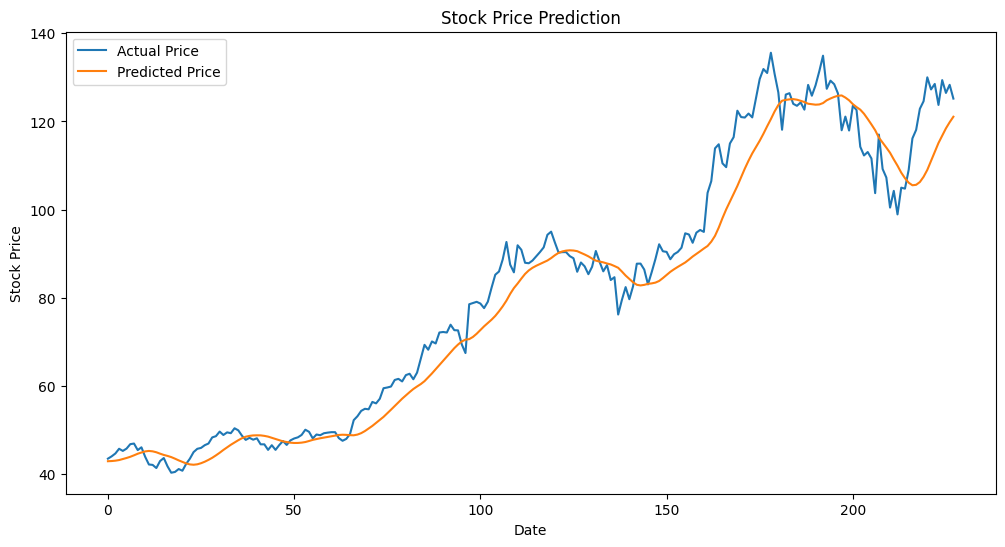

In [8]:
# 繪製實際值與預測值比較圖
plt.figure(figsize=(12, 6))
plt.plot(real, label='Actual Price')
plt.plot(predicted, label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Kaggle 資料集: https://www.kaggle.com/datasets/kalilurrahman/nvidia-stock-data-latest-and-updated